In [1]:
import numpy as np

In [2]:
# Dataset
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

N_SAMPLES = 1000
TEST_SIZE = 0.1

X, y = make_moons(n_samples = N_SAMPLES, noise=0.2, random_state=100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(900, 2) (900,)
(100, 2) (100,)


In [3]:
def sigmoid(Z):
    return 1/(1+np.exp(-Z))

def sigmoid_grad(Z):
    sig = sigmoid(Z)
    return sig * (1 - sig)

def relu(Z):
    return np.maximum(0,Z)

def relu_grad(Z):
    return Z > 0

In [8]:
def gradient_descent(layers, lr=0.01):
    for layer in layers:
        layer.w -= lr*layer.dw
        layer.b -= lr*layer.db

In [4]:
def get_cost_value(y, y_hat):
    m = y_hat.shape[0]
    cost = -1 / m * (np.dot(y, np.log(y_hat).T) + np.dot(1 - y, np.log(1 - y_hat).T))
    return np.squeeze(cost)

In [5]:
class DenseLayer():

    def __init__(self, w, b, activation):
        self.w = w.copy()
        self.b = b.copy()
        self.activation=activation
        self.dw = None
        self.db = None
        self.a_prev = None
        self.z_curr = None

    @classmethod
    def initialize(cls, nodes_prev, nodes_curr, activation, seed=99):
        np.random.seed(seed)
        w = np.random.randn(nodes_curr, nodes_prev) * 0.1
        b = np.random.randn(1, nodes_curr) * 0.1
        return cls(w=w, b=b, activation=activation)

    def set_weights(self, w, b):
        self.w = w
        self.b = b

    def weights(self):
        return self.w, self.b

    def forward_pass(self, a_prev):
        if self.activation == "relu":
            g = relu
        elif self.activation == "sigmoid":
            g = sigmoid
        else: 
            raise Exception('Wrong activation function!')
        self.a_prev = a_prev.copy()
        self.z_curr = a_prev @ self.w.T + self.b
        return g(self.z_curr)
        
    def back_pass(self, da_curr):
        if self.activation == "relu":
            g = relu_grad
        elif self.activation == "sigmoid":
            g = sigmoid_grad
        else: 
            raise Exception('Wrong activation function!')

        m = da_curr.shape[0]
        dz_curr = da_curr * g(self.z_curr)
        self.dw = (dz_curr.T @ self.a_prev)/m
        self.db = np.sum(dz_curr,axis=0, keepdims=True)/m
        return dz_curr @ self.w


In [6]:
class Model():

    def __init__(self, layers, optimizer):
        self.layers = layers
        self.optimizer = optimizer

    def predict(self, x):
        activation = x
        for layer in self.layers:
            activation = layer.forward_pass(activation)
        return activation
    
    def accuracy(self, x, y):
        y_hat = self.predict(x)[:,0]
        y_hat[y_hat > 0.5] = 1
        y_hat[y_hat <= 0.5] = 0
        return np.sum(y_hat == y)/len(y)

    def fit(self, x, y, epoch):
        C_history = []
        for i in range(epoch):
            y_hat = self.predict(x)[:,0]

            # Cost
            cost = get_cost_value(y=y, y_hat=y_hat)
            C_history.append(cost)

            # init 
            da_prev = np.divide(1 - y, 1 - y_hat) - np.divide(y, y_hat)
            da_prev = da_prev[:,np.newaxis]
            for layer in reversed(self.layers):
                da_curr = da_prev

                da_prev = layer.back_pass(da_curr)
            
            # gradient descent
            self.optimizer(self.layers)
        return C_history


# Test model

In [9]:
NN_ARCHITECTURE = [
    {"input_dim": 2, "output_dim": 25, "activation": "relu"},
    {"input_dim": 25, "output_dim": 50, "activation": "relu"},
    {"input_dim": 50, "output_dim": 50, "activation": "relu"},
    {"input_dim": 50, "output_dim": 25, "activation": "relu"},
    {"input_dim": 25, "output_dim": 1, "activation": "sigmoid"},
]

layers = []
for idx, layer in enumerate(NN_ARCHITECTURE):
    layers.append(DenseLayer.initialize(layer["input_dim"], layer["output_dim"], layer["activation"]))
    
model = Model(layers, optimizer=gradient_descent)

In [10]:
C_history = model.fit(X_train, y_train, epoch=10000)
model.accuracy(X_test,y_test)

0.98

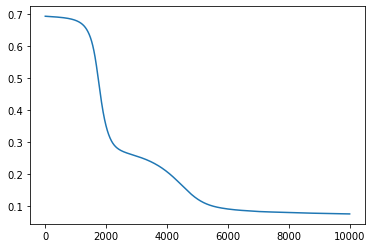

In [11]:
import matplotlib.pyplot as plt 

plt.plot(C_history)